## Vector Autoregressions (VAR)

This notebook will demonstrate how to estimate a vector autoregression. These models have become extremely common in both finance and macroeconomics. They are flexible, low-cost in terms of estimating, and are designed to better help you understand the time series properties of your variables.

In [1]:
import Haver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

As a reminder make sure your Haver path is set to whichever Haver database you are working with. 

In [2]:
Haver.path()

'R:\\\\'

In [3]:
Haver.path('C:\\Users\\RNAMG01\\Desktop\\python haver training\\US1PLUS\\')

In [4]:
Haver.path()

'C:\\Users\\RNAMG01\\Desktop\\python haver training\\US1PLUS'

Lets query the US1PLUS Haver database for the U.S. CPI and PPI indices. Remeber to set dates=True to ensure proper indexation with pandas.

In [5]:
df=Haver.data(['pcu','pa'], 'us1plus', dates=True)



In [6]:
df=df.dropna()

In [7]:
df.head()

,pcu,pa
1947-01-31,21.48,24.5
1947-02-28,21.62,24.7
1947-03-31,22.00,25.3
1947-04-30,22.00,25.1
1947-05-31,21.95,25.0


In [8]:
df.tail()

,pcu,pa
2018-07-31,251.286,204.3
2018-08-31,251.846,203.0
2018-09-30,251.994,203.2
2018-10-31,252.827,204.3
2018-11-30,252.876,201.5


It is always a good idea to quickly take a look at your data.

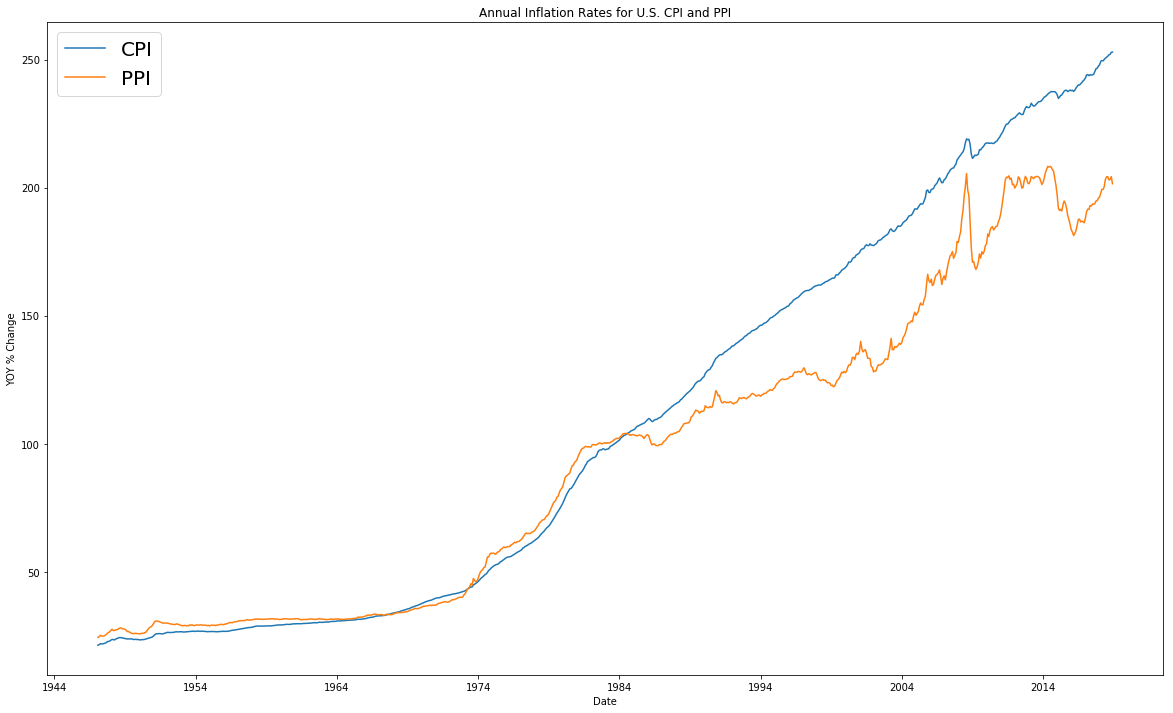

In [9]:
fig = plt.figure(figsize=(20,12))
fig= plt.plot(df, label=['CPI', 'PPI'])
plt.xlabel("Date")
plt.ylabel("YOY % Change")
plt.title('Annual Inflation Rates for U.S. CPI and PPI')
plt.legend(['CPI','PPI'], fontsize="20")
plt.show()

We are often interested in working with inflation rather than the price level. We can take the log and then difference the data year-over-year to end up with an inflation number we are use to working with.

In [11]:
# take the log and then difference the data year-over-year
ddf = np.log(df).diff(12).dropna()

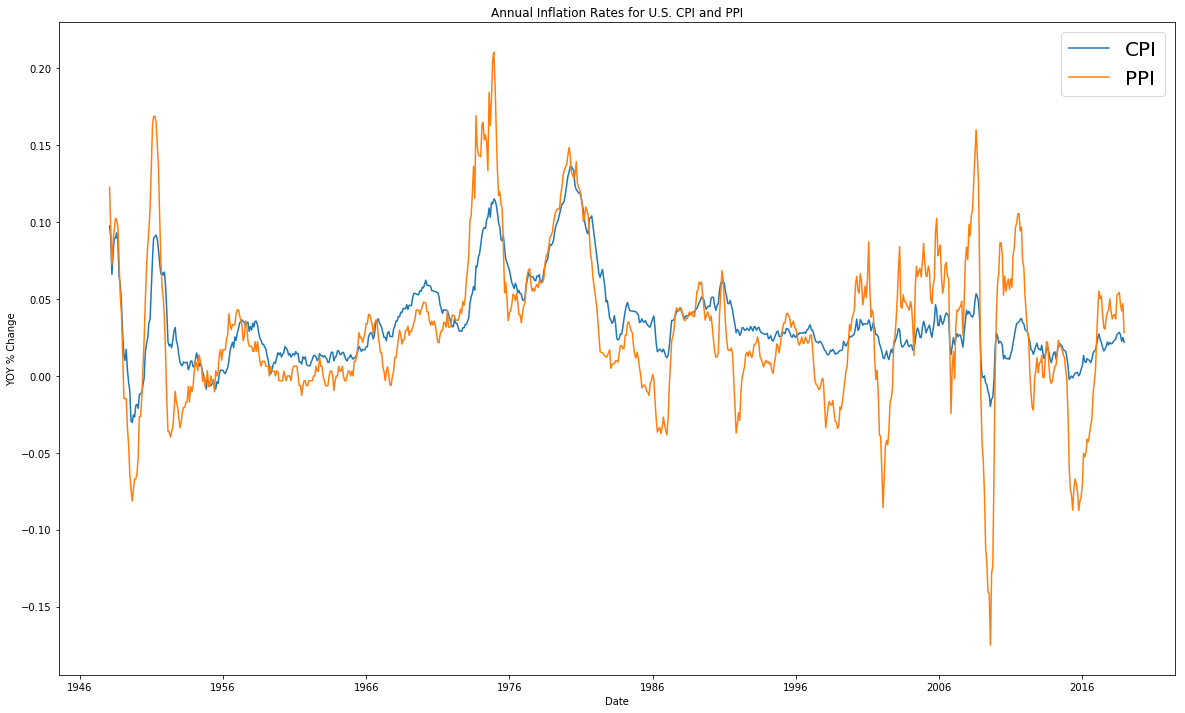

In [12]:
fig = plt.figure(figsize=(20,12))
fig= plt.plot(ddf, label=['CPI', 'PPI'])
plt.xlabel("Date")
plt.ylabel("YOY % Change")
plt.title('Annual Inflation Rates for U.S. CPI and PPI')
plt.legend(['CPI','PPI'], fontsize="20")
plt.show()

Estimating a vector autoregression is pretty simple in Python. the VAR command will create the model and the fit command will perform the estimation. 

In [17]:
model = VAR(ddf)
results = model.fit(2) #two variables & two lags
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Jan, 2019
Time:                     10:15:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.6210
Nobs:                     849.000    HQIC:                  -20.6555
Log likelihood:           6377.97    FPE:                1.04750e-09
AIC:                     -20.6769    Det(Omega_mle):     1.03527e-09
--------------------------------------------------------------------
Results for equation pcu
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000640         0.000226            2.830           0.005
L1.pcu         1.194549         0.042232           28.285           0.000
L1.pa          0.096743         0.015682            6.169           0.000
L2.pcu        -0

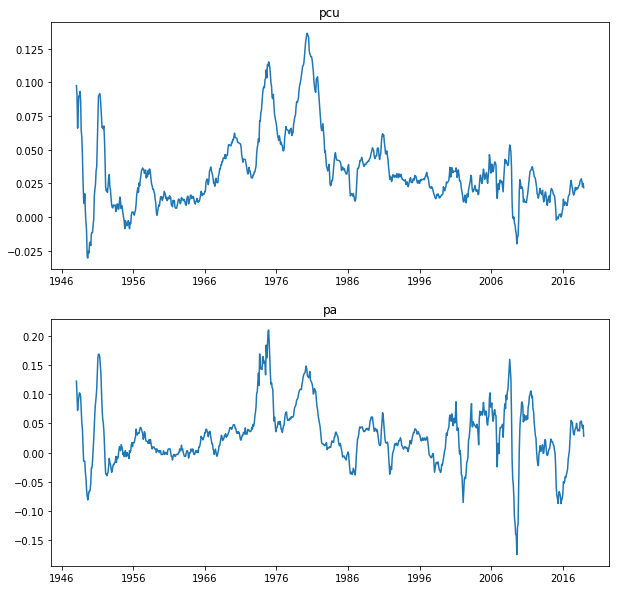

In [16]:
x=results.plot()

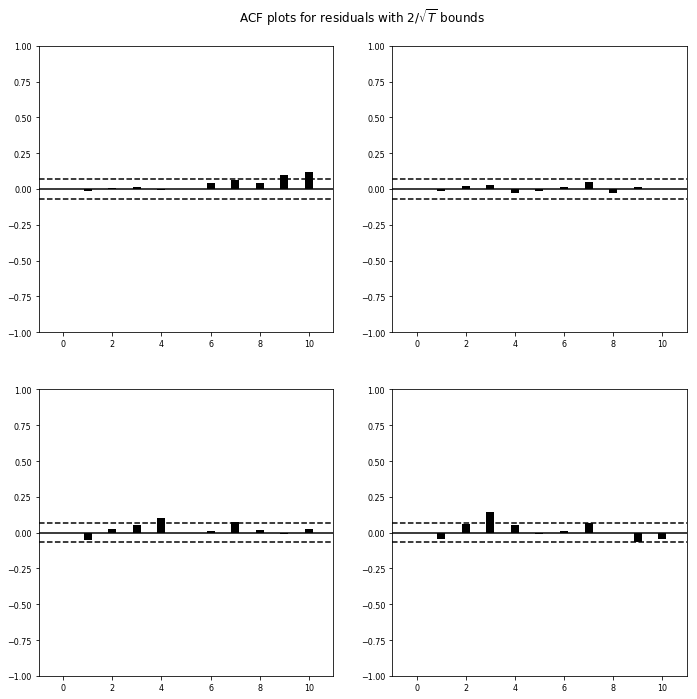

In [18]:
x=results.plot_acorr()

Lag selection in a VAR can be automated using information criteria such as AIC or BIC. You can choose the max number of lags you will allow and the information criteria of your choice. Remember that VARs use up degrees of freedom quickly so be conscious of your lag length.

In [19]:
results = model.fit(maxlags=20, ic='aic')

In [20]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Jan, 2019
Time:                     10:23:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.0418
Nobs:                     833.000    HQIC:                  -21.3006
Log likelihood:           6648.78    FPE:                4.77993e-10
AIC:                     -21.4615    Det(Omega_mle):     4.38201e-10
--------------------------------------------------------------------
Results for equation pcu
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000386         0.000195            1.980           0.048
L1.pcu          1.185786         0.043717           27.124           0.000
L1.pa           0.094330         0.015082            6.254           0.000
L2.pcu     

Vector autoregressions are widely used for forecasting. They have performed as well as structural equations and other types of forecasting models. 

In [21]:
lag_order= results.k_ar
forecast=results.forecast(ddf.values[-lag_order:], 12)
forecast= pd.DataFrame(forecast, columns=['CPI', 'PPI'])
forecast

,CPI,PPI
0,0.021385,0.026854
1,0.020770,0.026446
2,0.020074,0.020928
3,0.019159,0.016264
4,0.018229,0.016853
5,0.016717,0.008039
6,0.015270,0.003707
7,0.013899,0.000763
8,0.014414,0.003054
9,0.016946,0.007651


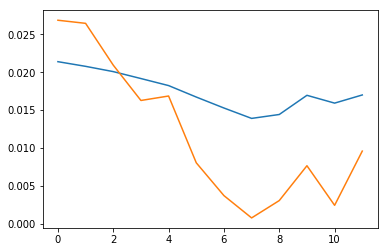

In [22]:
plt.plot(forecast)

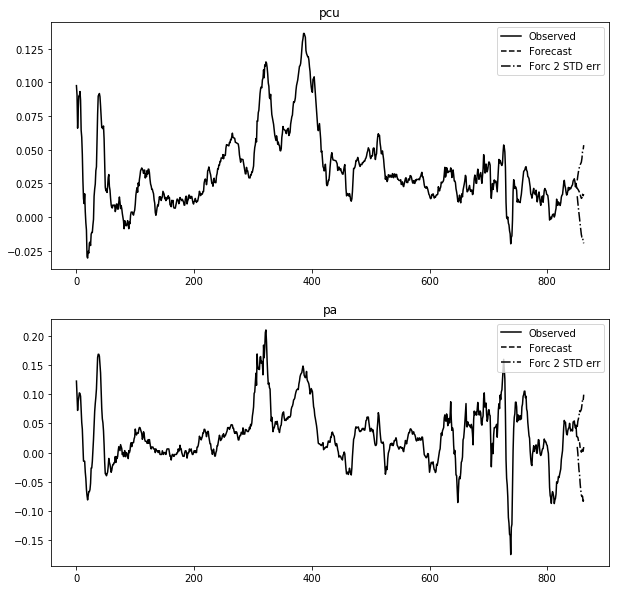

In [23]:
x=results.plot_forecast(12)

Impulse response functions allow you to shock the error term of one equation and see how that 1 standard deviation shock affects the other variables in system. It is based on the estimated coefficients from the underlying VAR model. 

In [24]:
irf = results.irf(10)

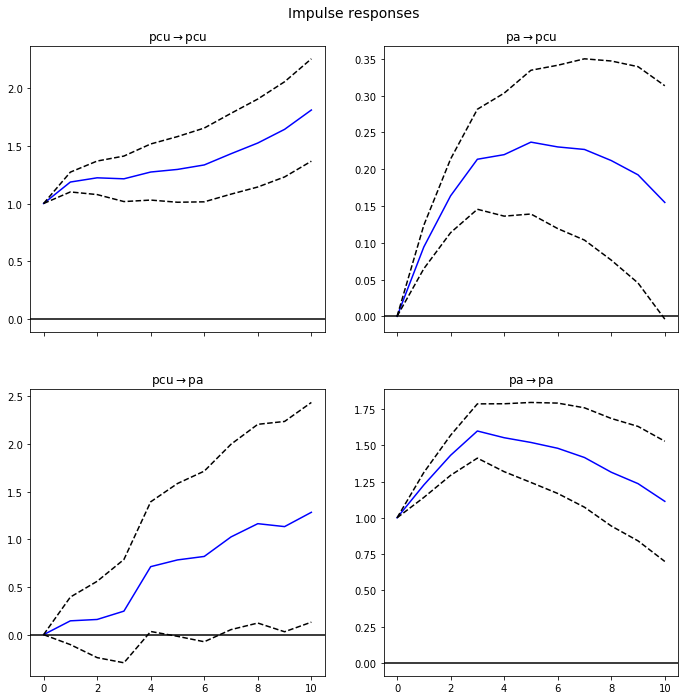

In [25]:
x=irf.plot(orth=False)

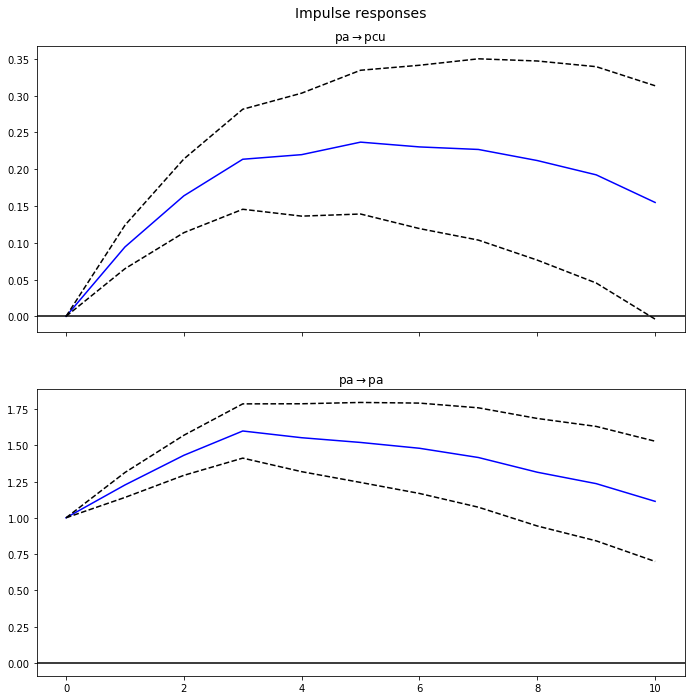

In [26]:
x=irf.plot(impulse='pa')

You can also perform an impulse response and calculate the cumulative effect of the 1 SD shock over a given set of periods.

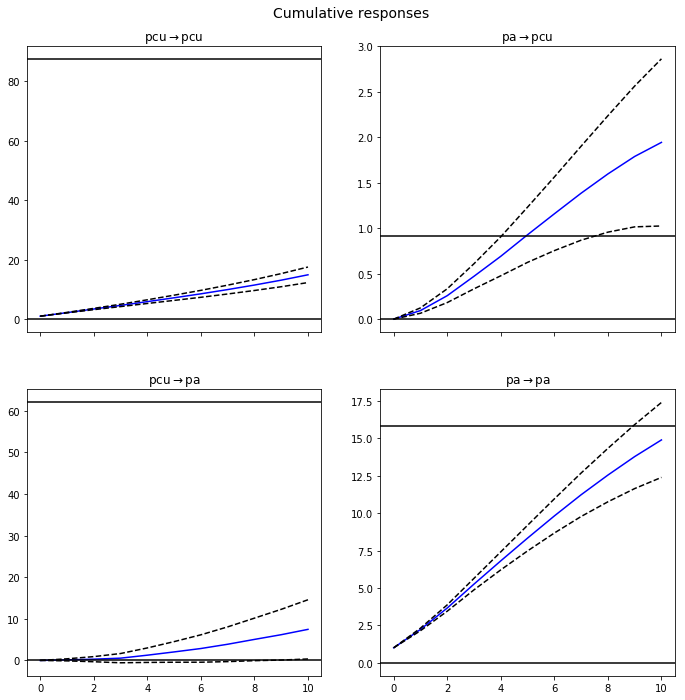

In [27]:
x=irf.plot_cum_effects(orth=False)

Granger causality tests statistically test whether lags of one variable have any incremental explanatory power on the other variable(s). Don't let the name fool you. This is not a test of causation. 

In [32]:
granger=results.test_causality('pcu', ['pa'], kind='f')

In [33]:
print(granger)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: pa does not Granger-cause pcu: reject at 5% significance level. Test statistic: 4.359, critical value: 1.610>, p-value: 0.000>


In [34]:
granger=results.test_causality('pa', ['pcu'], kind='f')

In [35]:
print(granger)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: pcu does not Granger-cause pa: reject at 5% significance level. Test statistic: 1.962, critical value: 1.610>, p-value: 0.009>
